# Synthetic Tests

In [ ]:
import numpy as np
import pandas as pd
import requests
import io
from scipy import interpolate
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import json
import ast

from gen_synth_data import gen_data, distort_data

from sedprep.kalman_filter import Filter
from sedprep.utils import lif
from sedprep.data_handling import add_identifier, read_arch_data, clean_data
from sedprep.constants import field_params
from sedprep.plot_functions import plot_DIF

folder = "../dat"

In [2]:
np.random.seed(1000)
new_sample_from_prior = False    # set to True to generate a new reference model
# We use the temporal and spartial distribution of real archaeo data and the sed_data_KLK.csv
pre = "https://nextcloud.gfz-potsdam.de/s/"
rejection_response = requests.get(f"{pre}WLxDTddq663zFLP/download")
rejection_response.raise_for_status()
with np.load(io.BytesIO(rejection_response.content), allow_pickle=True) as fh:
    to_reject = fh['to_reject']
data_response = requests.get(f"{pre}r6YxrrABRJjideS/download")
arch_real = read_arch_data(io.BytesIO(data_response.content), to_reject)

# arch_real = pd.read_csv("../dat/synth_data/arch.csv")

sed_real = pd.read_csv("../dat/P3.csv")

knots, dt = np.linspace(
    min(arch_real["t"]), max(arch_real["t"]), 2000, retstep=True
)
knots = np.concatenate((
    [min(knots) - 2], [min(knots) - 1], knots, [max(knots) + 1], [max(knots) + 2]
))
if new_sample_from_prior:
    model = Filter(**field_params)
    prior_sample = model.sample_prior(ts=knots, n_samps=10)[0, :, :]
    np.save("../dat/prior_sample.npy", prior_sample)
else:
    prior_sample = np.load("../dat/prior_sample.npy")
vals = np.insert(prior_sample.T, [prior_sample.T.shape[0], 0], [prior_sample.T[-1], prior_sample.T[0]], axis=0)
spline = interpolate.BSpline(knots, vals, 1)

Rejected 347 outliers.


c:\users\lukas\documents\gfz\sedprep\sedprep\data_handling.py:547: UserWarning: Records with indices [   72    73    74    75    76    77    78    79    80    81   108   109
   357   358  1065  1066  1153  2402  2575  2671  2753  2756  2757  3036
  3215  3217  3218  3219  3220  3221  3222  3223  3224  3225  3503  3772
  3988  4047  4235  4415  4504  4530  4531  4655  5172  5326  5434  5496
  5551  5707  5763  5802  5805  5959  6053  6105  6647  6706  6781  6809
  7149  7580  7585  7593  7692  7702  7735  7776  7806  7826  7881  7979
  8067  8296  8327  8427  8464  8510  8670  8708  8752  9224  9653 10002
 10132 10331 10509 10604 10647 11527 11758] contain declination, but not inclination! The errors need special treatment!
To be able to use the provided data, these records have been dropped from the output.


In [3]:
np.random.seed(1000)
gen_new_arch_data = False        # set to True to generate new synthetic arch data

if gen_new_arch_data:
    arch, _ = gen_data(
        t=arch_real["t"],       # use temporal distribution of real arch data
        lat=arch_real["lat"],   # use spatial distribution of real arch data
        lon=arch_real["lon"],   # use spatial distribution of real arch data
        field_spline=spline,    # use previously generated prior sample
        dt=arch_real["dt"],     # use temporal errors of real arch data
        ddec=arch_real["dD"],   # use measurement errors of real arch data
        dinc=arch_real["dI"],   # use measurement errors of real arch data
        dint=arch_real["dF"],   # use measurement errors of real arch data
        depth=None,             # arch data does not has depth
        with_noise=True,        # add some noise to synthetic arch data
    )
    arch["type"] = "arch_data"
    # # To use your new data store it as a csv file using 
    arch.to_csv(f"{folder}/arch.csv", index=False)
    # # Then run the following line to add unique identifiers
    add_identifier(f"{folder}/arch.csv")
else:
    arch = pd.read_csv(f"{folder}/arch.csv")

In [4]:
np.random.seed(1000)
gen_new_ref_sed_data = False     # set to True to generate new reference sediment data

ref_sed_dfs = {}
ref_sed_NEZs = {}
lats = {"sweden": sed_real["lat"][0], "rapa": -27.616}
lons = {"sweden": sed_real["lon"][0], "rapa": -144.283}
for loc in ["sweden", "rapa"]:
    if gen_new_ref_sed_data:
        ref_sed, ref_sed_NEZ = gen_data(
            t=sed_real["t"],        # use temporal distribution of real sed data
            lat=lats[loc],          # use latitude distribution of real sed data (-27.616 for rapa)
            lon=lons[loc],          # use longitude distribution of real sed data (-144.283 for rapa)
            field_spline=spline,    # use previously generated prior sample
            dt=sed_real["dt"],      # use temporal errors of real sed data
            depth=sed_real["depth"],# use depth of real sed data
            with_noise=False,       # no noise for reference process
        )
        # Store the data as a csv file using 
        ref_sed.to_csv(f"{folder}/ref_sed_{loc}.csv", index=False)
        np.save(f"{folder}/ref_sed_{loc}_NEZ.npy", ref_sed_NEZ)
        ref_sed_NEZs[loc] = np.load(f"{folder}/ref_sed_{loc}_NEZ.npy")
        ref_sed_dfs[loc] = pd.read_csv(f"{folder}/ref_sed_{loc}.csv")
    else:
        ref_sed_NEZs[loc] = np.load(f"{folder}/ref_sed_{loc}_NEZ.npy")
        ref_sed_dfs[loc] = pd.read_csv(f"{folder}/ref_sed_{loc}.csv")

In [5]:
np.random.seed(1000)
gen_new_sed_data = False  # set to True to generate new synthetic sed data

# since sed_real has no intensity errors we use the following
dint = np.random.normal(4, 2, len(sed_real)).clip(0.1, None)
# add two subsections
subsections={"A1": np.arange(0, 60, 1), "A2": np.arange(60, len(ref_sed_dfs["sweden"]), 1)}
bs_DIs = {"triangle": [10, 10, 0, 10], "square": [5, 1, 20, 1], "ramp": [1, 1, 0, 20]}
bs_Fs = bs_DIs
# offset parameters for two sections
offsets = {"A1": 30., "A2": -10.}
f_shallow=0.6
cal_fac = 90

sed_dfs = {}
for loc in ["sweden", "rapa"]:
    ref_sed = ref_sed_dfs[loc]
    ref_sed_NEZ = ref_sed_NEZs[loc]
    for file in ["triangle", "square", "ramp"]:
        name = f"{loc}_{file}"
        if gen_new_sed_data:
            sed = distort_data(
                ref_sed_dfs[loc],
                ref_sed_NEZs[loc],
                ddec=sed_real["dD"],    # use measurement errors of real sed data
                dinc=sed_real["dI"],    # use measurement errors of real sed data
                dint=dint,              # measurement errors for intensity
                bs_DI=bs_DIs[file],     # lock-in function parameters for directions
                bs_F=bs_Fs[file],       # lock-in function parameters for intensity
                offsets=offsets,        # declination offsets per sections
                f_shallow=f_shallow,    # inclination shallowing factor
                cal_fac=cal_fac,        # calibration factor for intensity
                subsections=subsections,# subsections
            )
            sed["type"] = "sediments"
            sed.to_csv(f"{folder}/sed_{name}.csv", index=False)
            # Add unique identifiers
            add_identifier(f"{folder}/sed_{name}.csv")
            sed_dfs[name] = pd.read_csv(f"{folder}/sed_{name}.csv")
        else:
            sed_dfs[name] = pd.read_csv(f"{folder}/sed_{name}.csv")


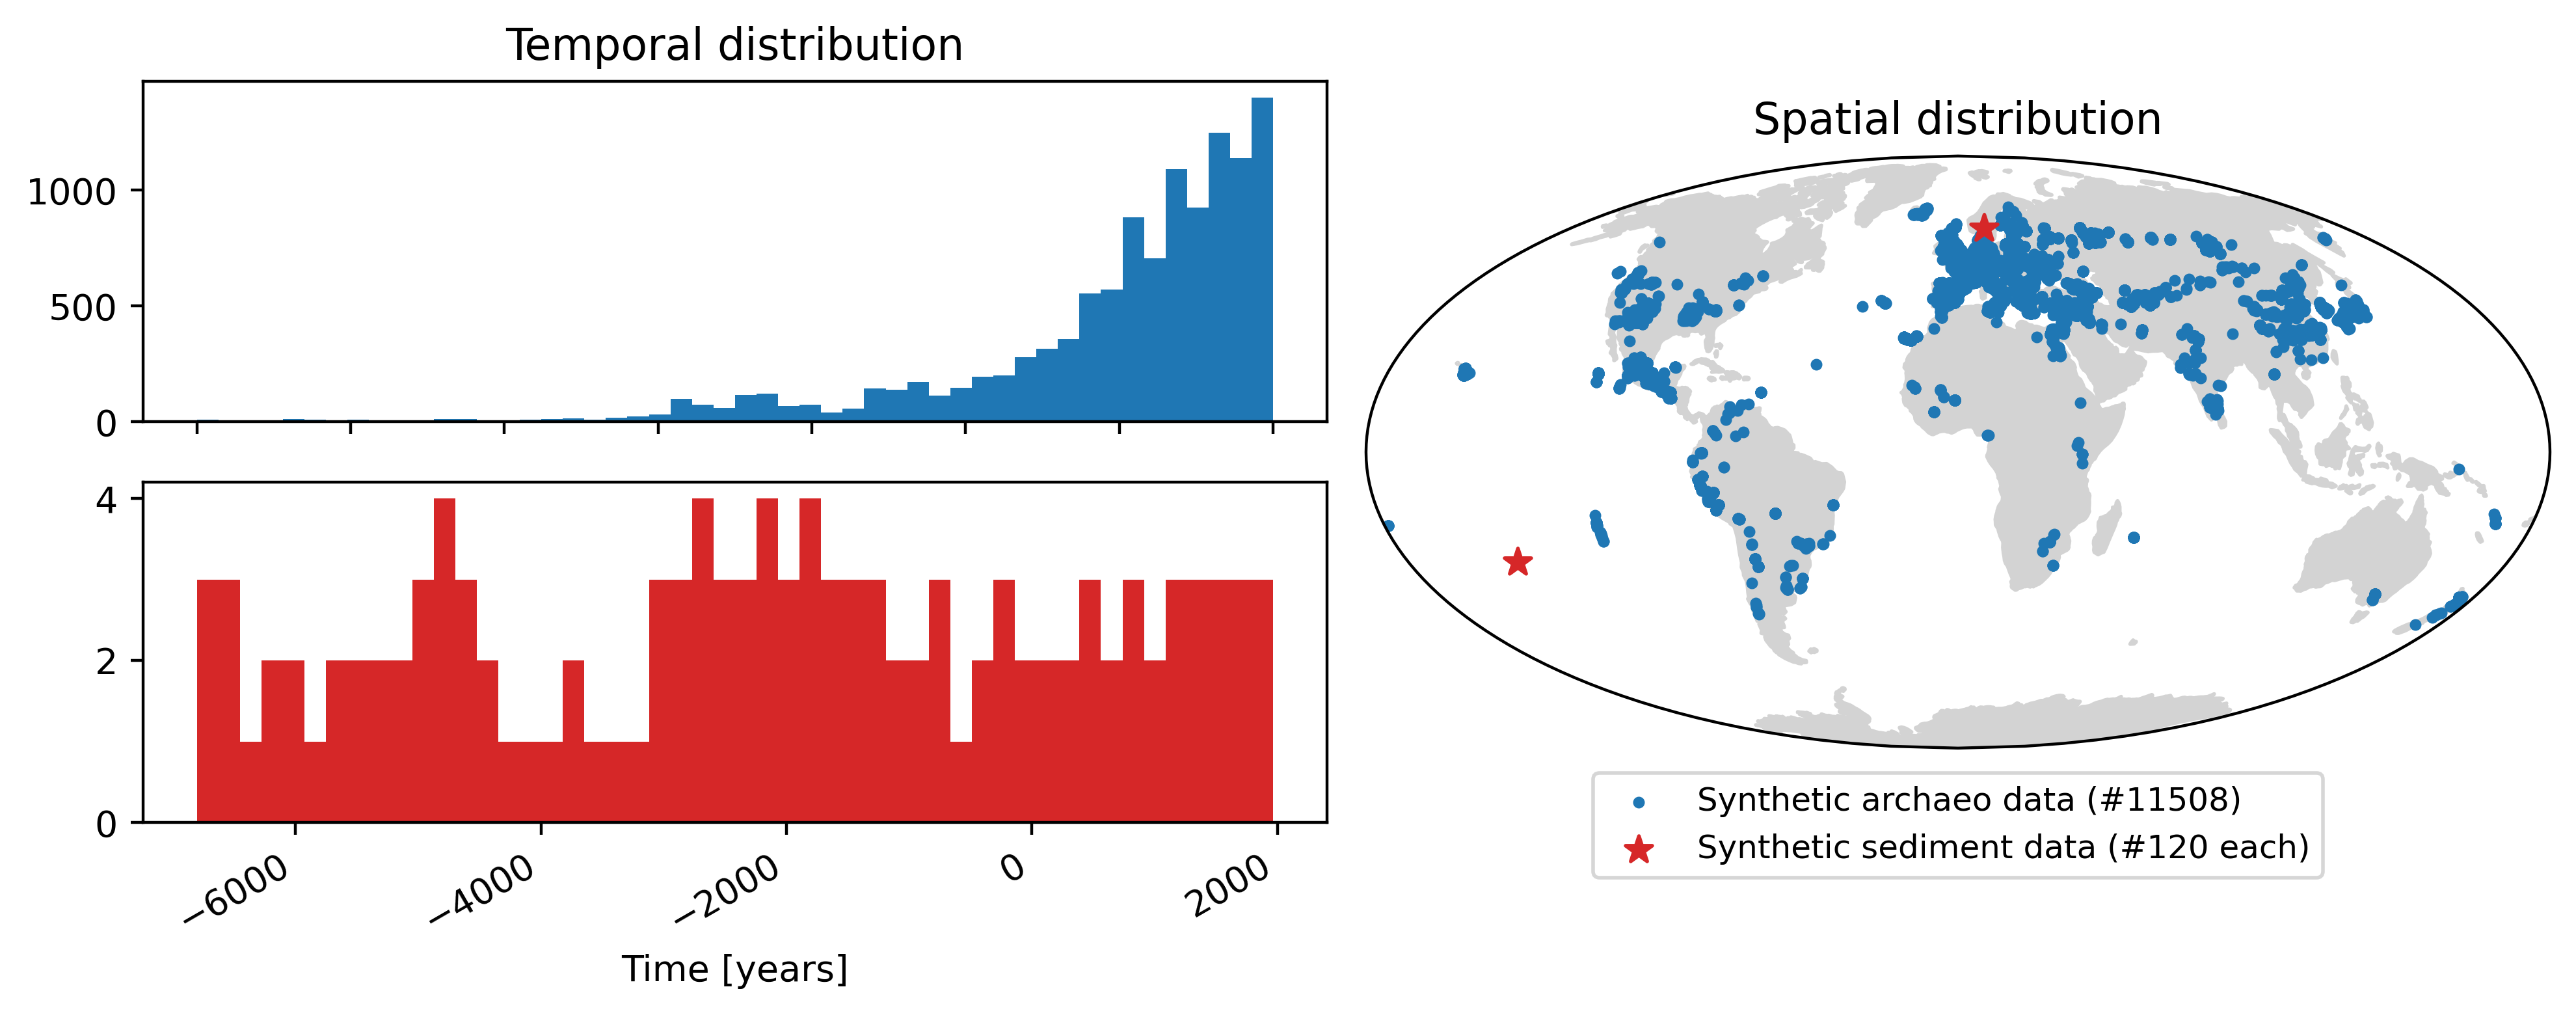

In [6]:
proj = ccrs.Mollweide()
fig = plt.figure(figsize=(10, 4), dpi=400)
arch_temp_dist = fig.add_subplot(2, 2, 1)
sed_temp_dist = fig.add_subplot(2, 2, 3)
sph_ax = fig.add_subplot(1, 2, 2, projection=proj)

arch_temp_dist.hist(arch.t, bins=50, color="C0")
arch_temp_dist.set_title("Temporal distribution")
sed_temp_dist.hist(ref_sed_dfs["rapa"].t, bins=50, color="C3")
sed_temp_dist.set_xlabel("Time [years]")

sph_ax.set_title("Spatial distribution")
sph_ax.set_global()
sph_ax.add_feature(cfeature.LAND, zorder=0, color="lightgray")
sph_ax.scatter(
    arch.lon,
    arch.lat,
    c="C0",
    label="Synthetic archaeo data (#" + str(int(len(arch))) + ")",
    s=5,
    alpha=1,
    zorder=1,
    rasterized=True,
    transform=ccrs.PlateCarree(),
)
for i, sed_data in enumerate(
    [ref_sed_dfs["sweden"], ref_sed_dfs["rapa"]]
):
    sph_ax.scatter(
        sed_data.lon[0],
        sed_data.lat[0],
        c="C3",
        label="Synthetic sediment data (#" + str(int(len(sed_data))) + " each)" if i == 0 else None,
        s=60,
        marker="*",
        alpha=1,
        zorder=1,
        rasterized=True,
        transform=ccrs.PlateCarree(),
    )
sph_ax.legend(loc="center", prop={"size": 9}, bbox_to_anchor=(0.5, -0.13), ncol=1)
fig.autofmt_xdate()
fig.tight_layout()

In [7]:
preprocess_data = False     # set to True to apply estimated parameters to clean data
prep_dfs = {}
for loc in ["sweden", "rapa"]:
    for file in ["triangle", "square", "ramp"]:
        name = f"{loc}_{file}"
        sed = pd.read_csv(f"{folder}/sed_{name}.csv")
        res_DI = pd.read_csv(f"../results/sed_{name}_DI.csv")
        res_F = pd.read_csv(f"../results/sed_{name}_F.csv")
        est_bs_DI_4p = ast.literal_eval(res_DI[res_DI.optimizer=="scipy"].bs_DI.values[0])
        est_bs_F_4p = ast.literal_eval(res_F[res_F.optimizer=="scipy"].bs_F.values[0])
        est_bs_DI_2p = ast.literal_eval(res_DI[res_DI.optimizer=="scipy"].bs_DI.values[1])
        est_bs_F_2p = ast.literal_eval(res_F[res_F.optimizer=="scipy"].bs_F.values[1])
        est_offsets_4p = json.loads(res_DI[res_DI.optimizer=="scipy"].offsets.values[0].replace("'", '"'))
        est_offsets_2p = json.loads(res_DI[res_DI.optimizer=="scipy"].offsets.values[1].replace("'", '"'))
        est_f_shallow_4p = res_DI[res_DI.optimizer=="scipy"].f_shallow.values[0]
        est_f_shallow_2p = res_DI[res_DI.optimizer=="scipy"].f_shallow.values[1]
        est_cal_fac_4p = res_F[res_F.optimizer=="scipy"].cal_fac.values[0]
        est_cal_fac_2p = res_F[res_F.optimizer=="scipy"].cal_fac.values[1]
        if preprocess_data:
            prep_dfs[name + "_4p"] = clean_data(
                sed,
                est_bs_DI_4p,
                est_bs_F_4p,
                est_offsets_4p,
                est_f_shallow_4p,
                est_cal_fac_4p,
            )
            prep_dfs[name + "_4p"].to_csv(
                f"../results/preprocessed/sed_{name}_preprocessed_4p.csv", index=False
            )
            prep_dfs[name + "_2p"] = clean_data(
                sed,
                est_bs_DI_2p,
                est_bs_F_2p,
                est_offsets_2p,
                est_f_shallow_2p,
                est_cal_fac_2p,
            )
            prep_dfs[name + "_2p"].to_csv(
                f"../results/preprocessed/sed_{name}_preprocessed_2p.csv", index=False
            )
        else:
            prep_dfs[name + "_4p"] = pd.read_csv(f"../results/preprocessed/sed_{name}_preprocessed_4p.csv")
            prep_dfs[name + "_2p"] = pd.read_csv(f"../results/preprocessed/sed_{name}_preprocessed_2p.csv")

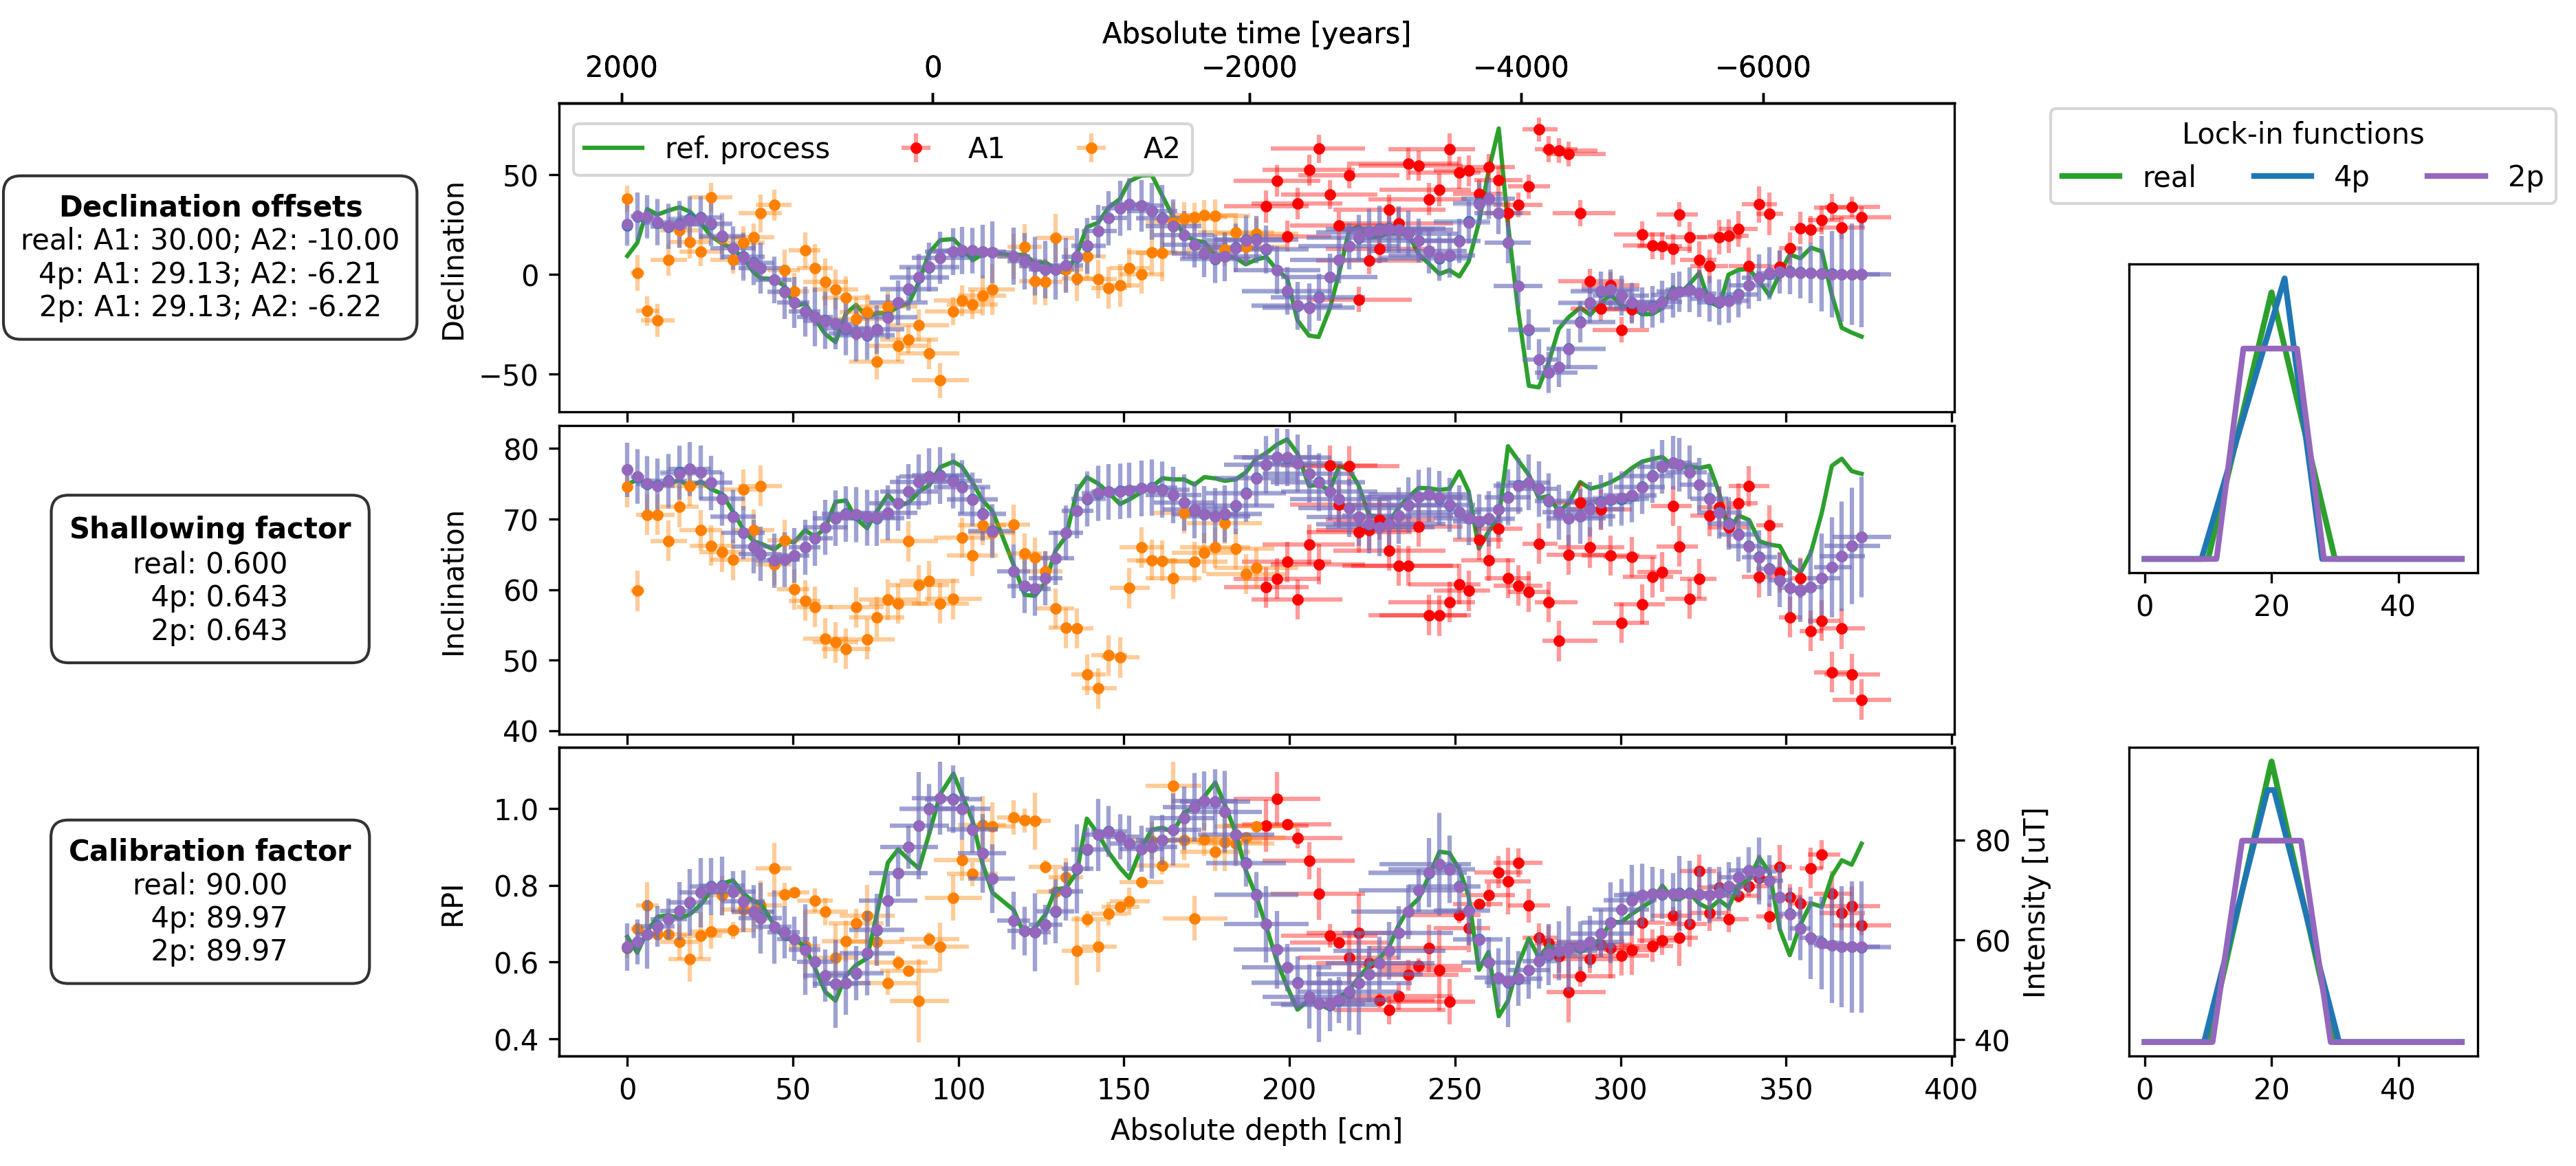

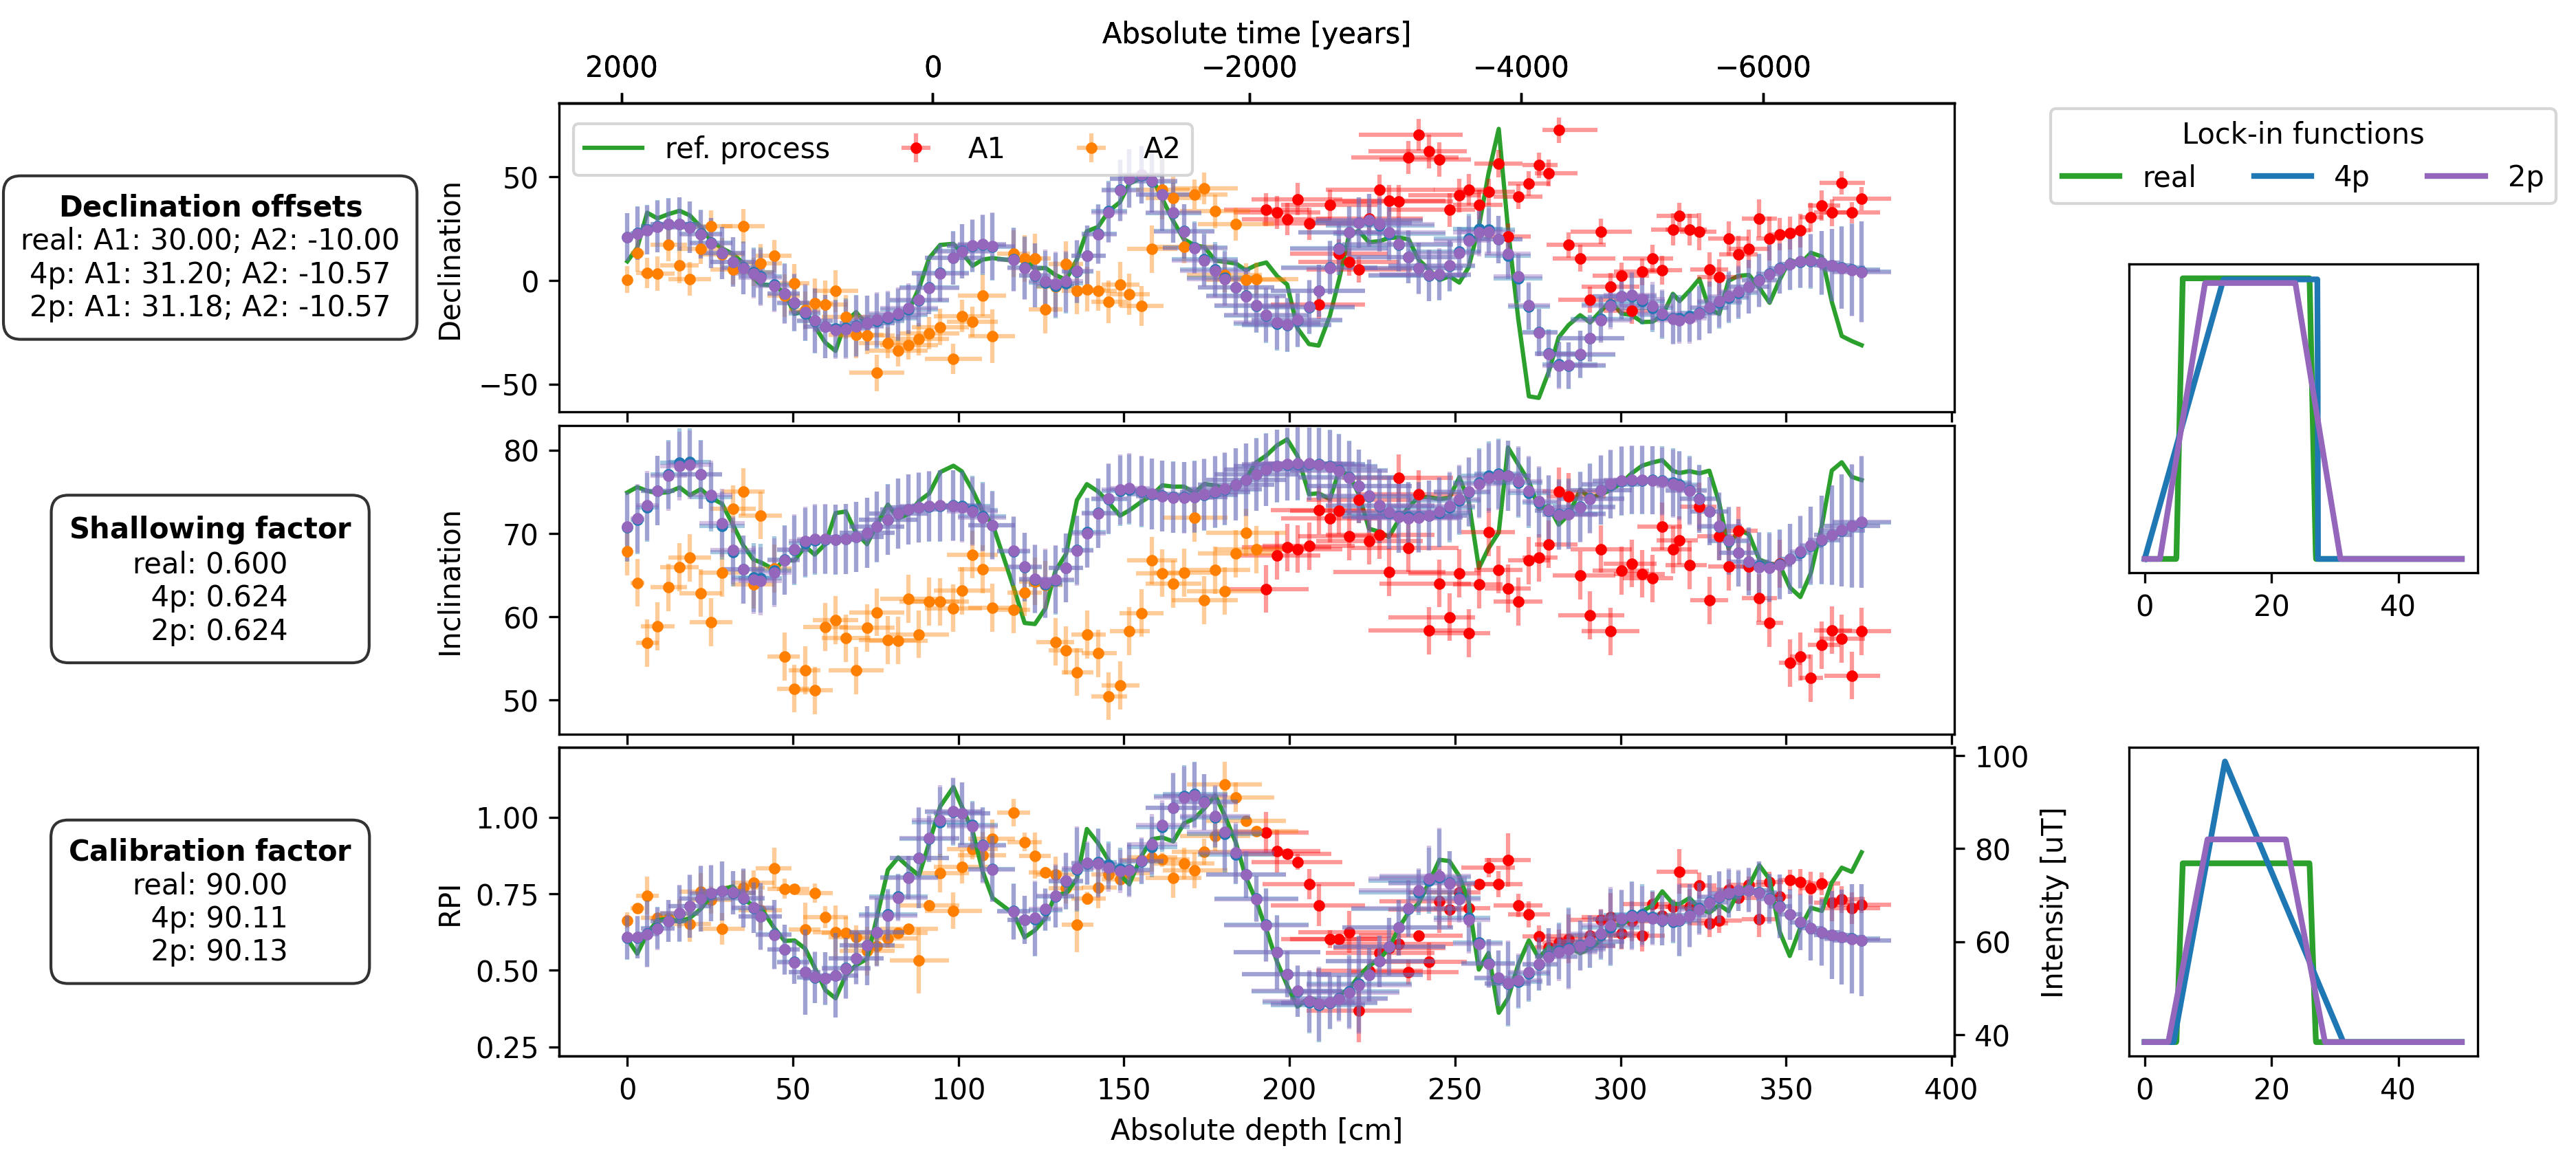

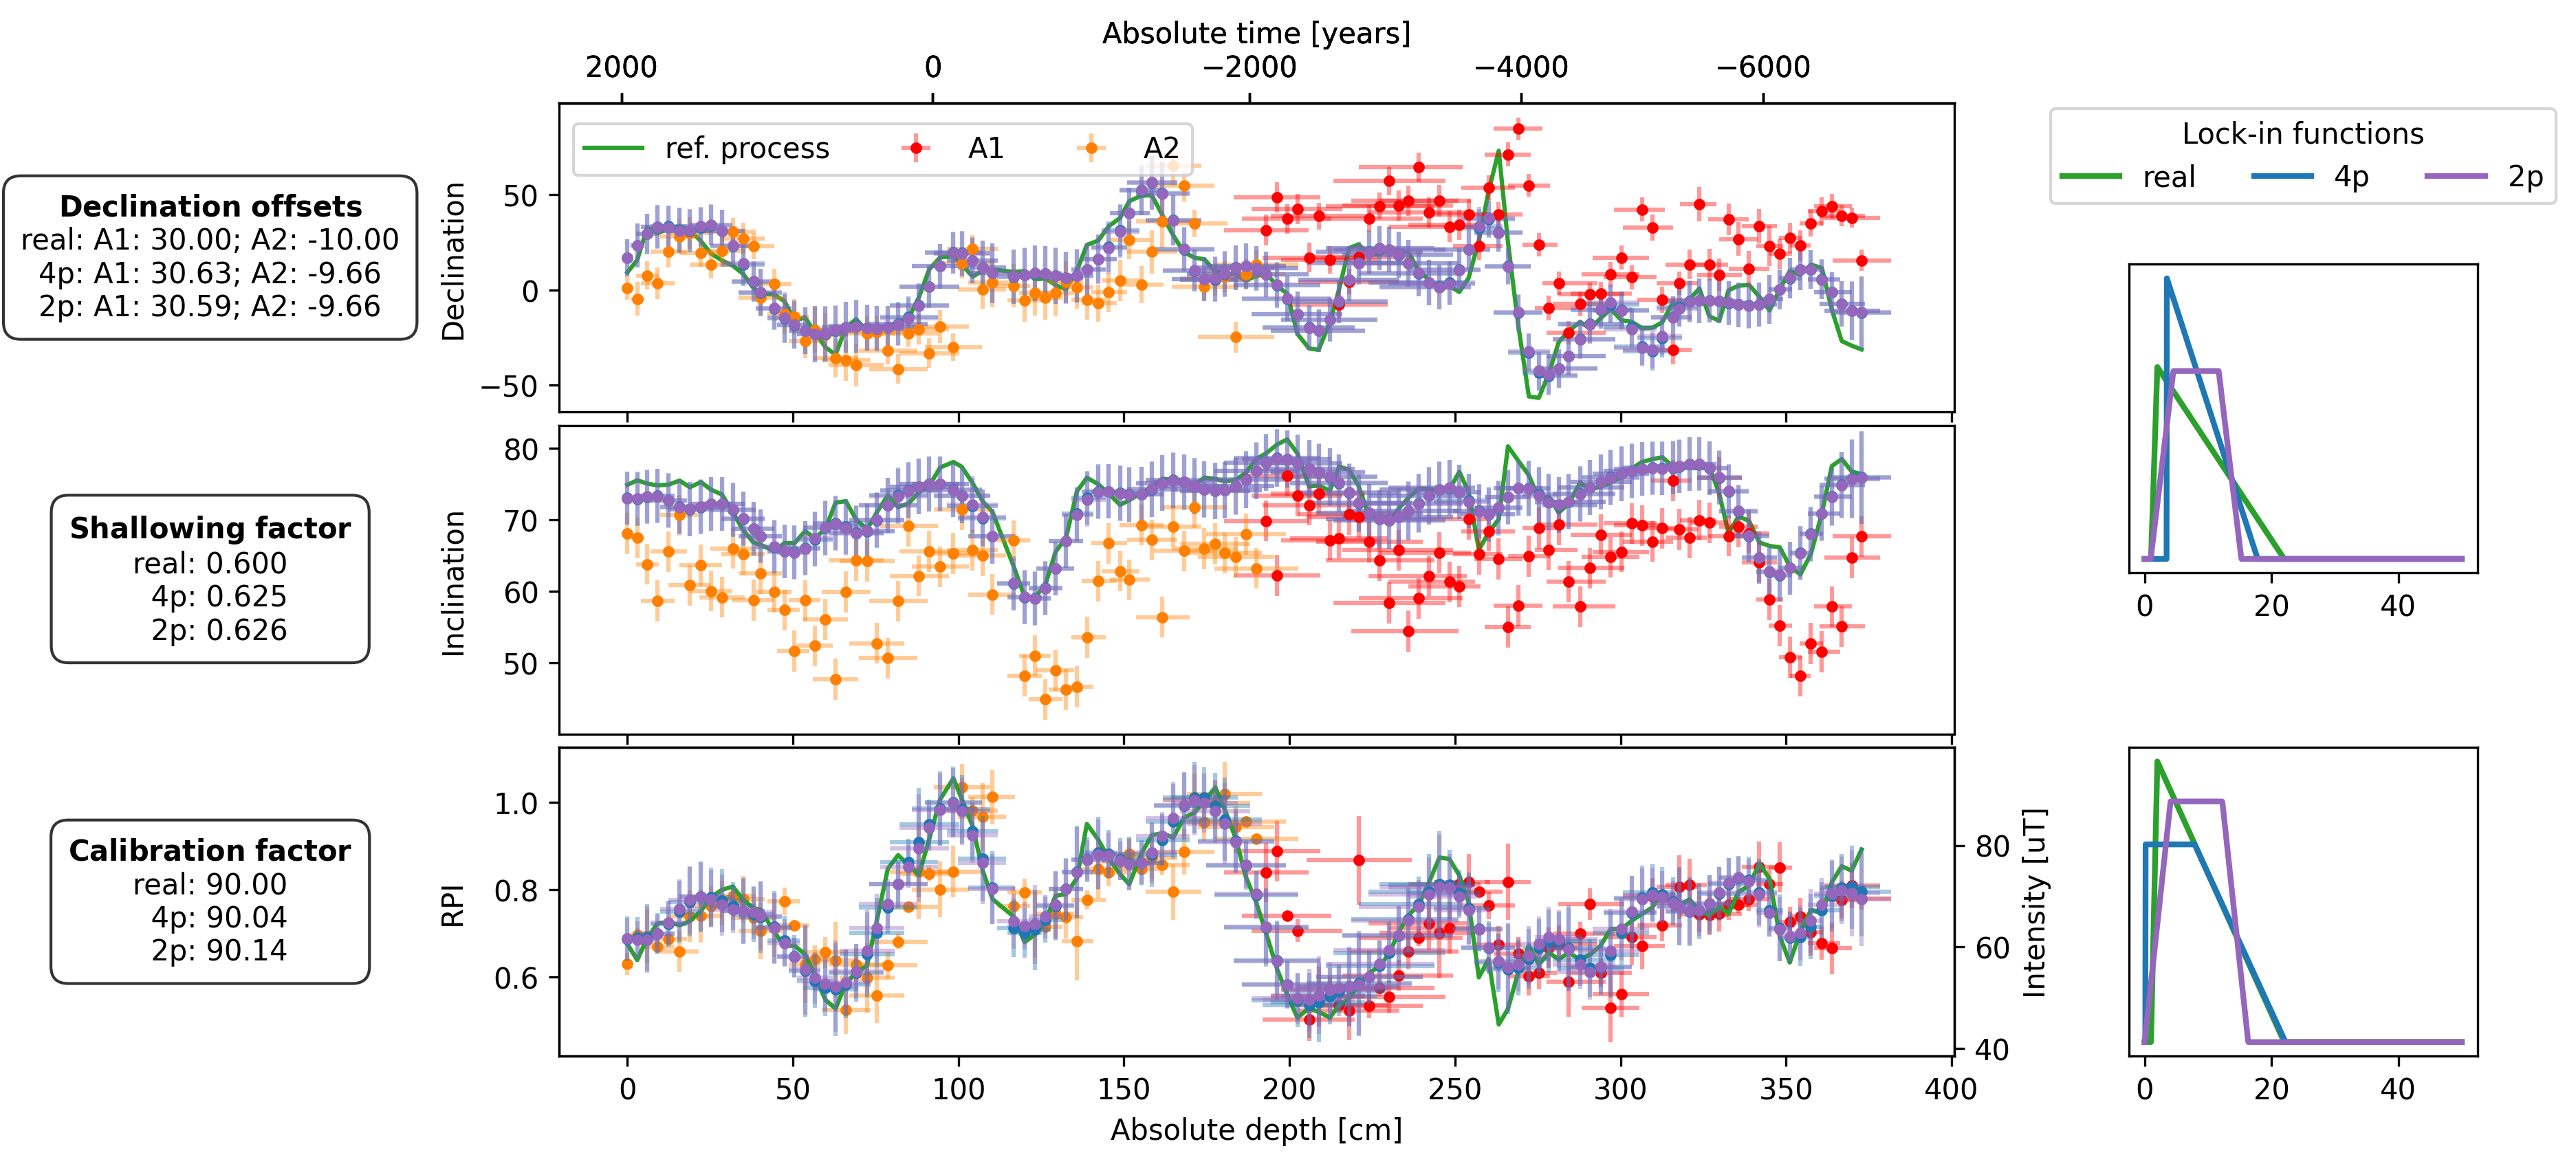

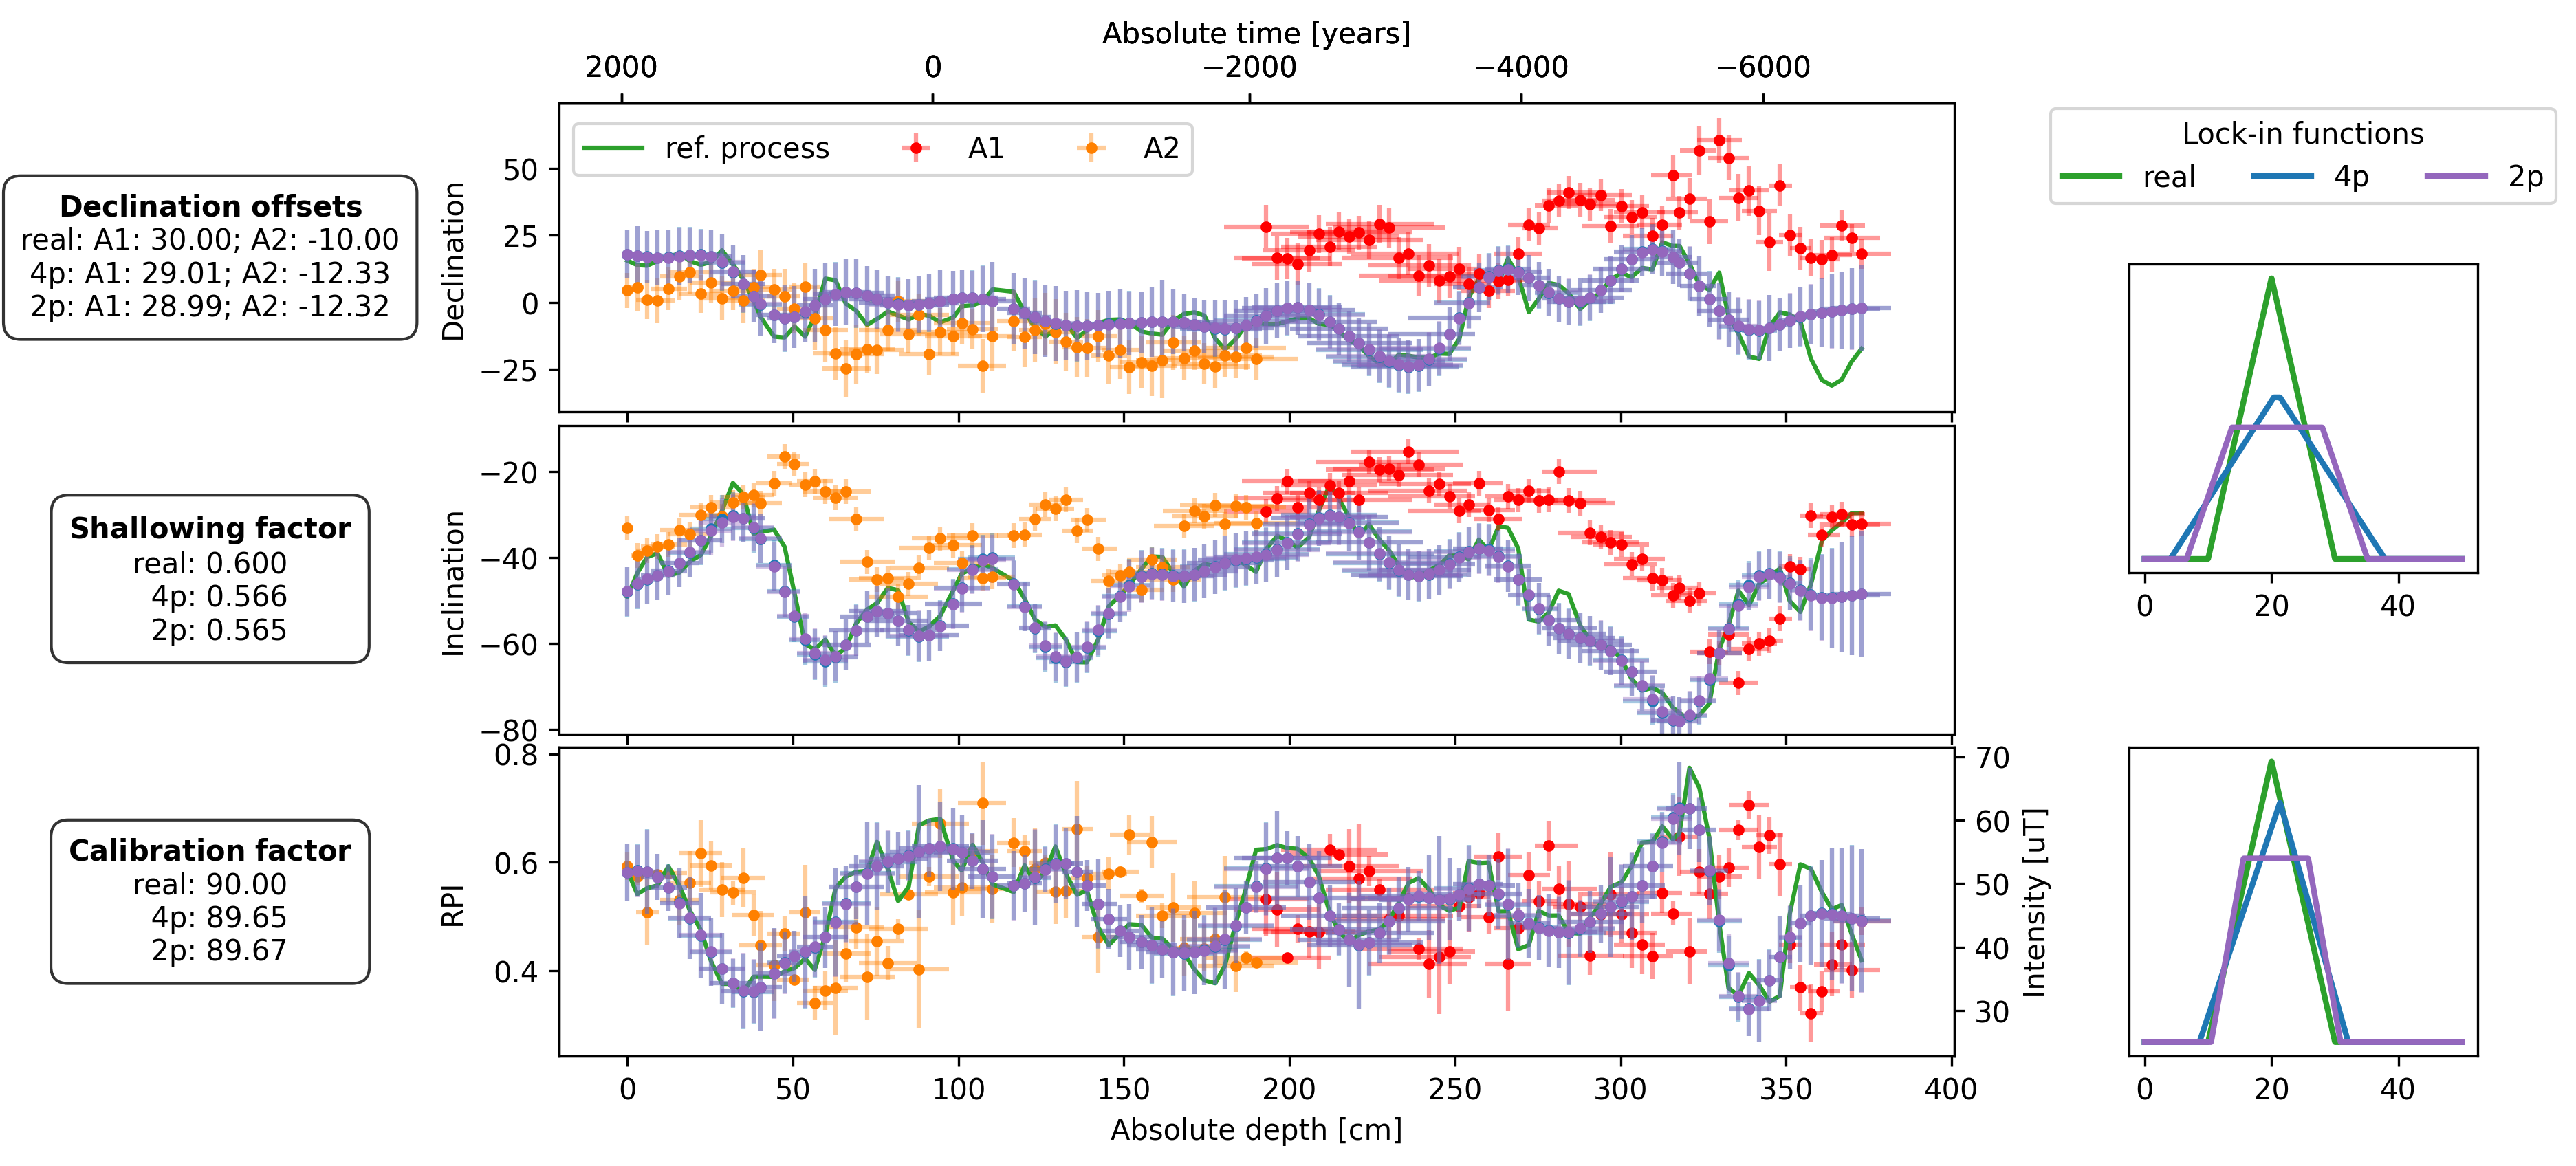

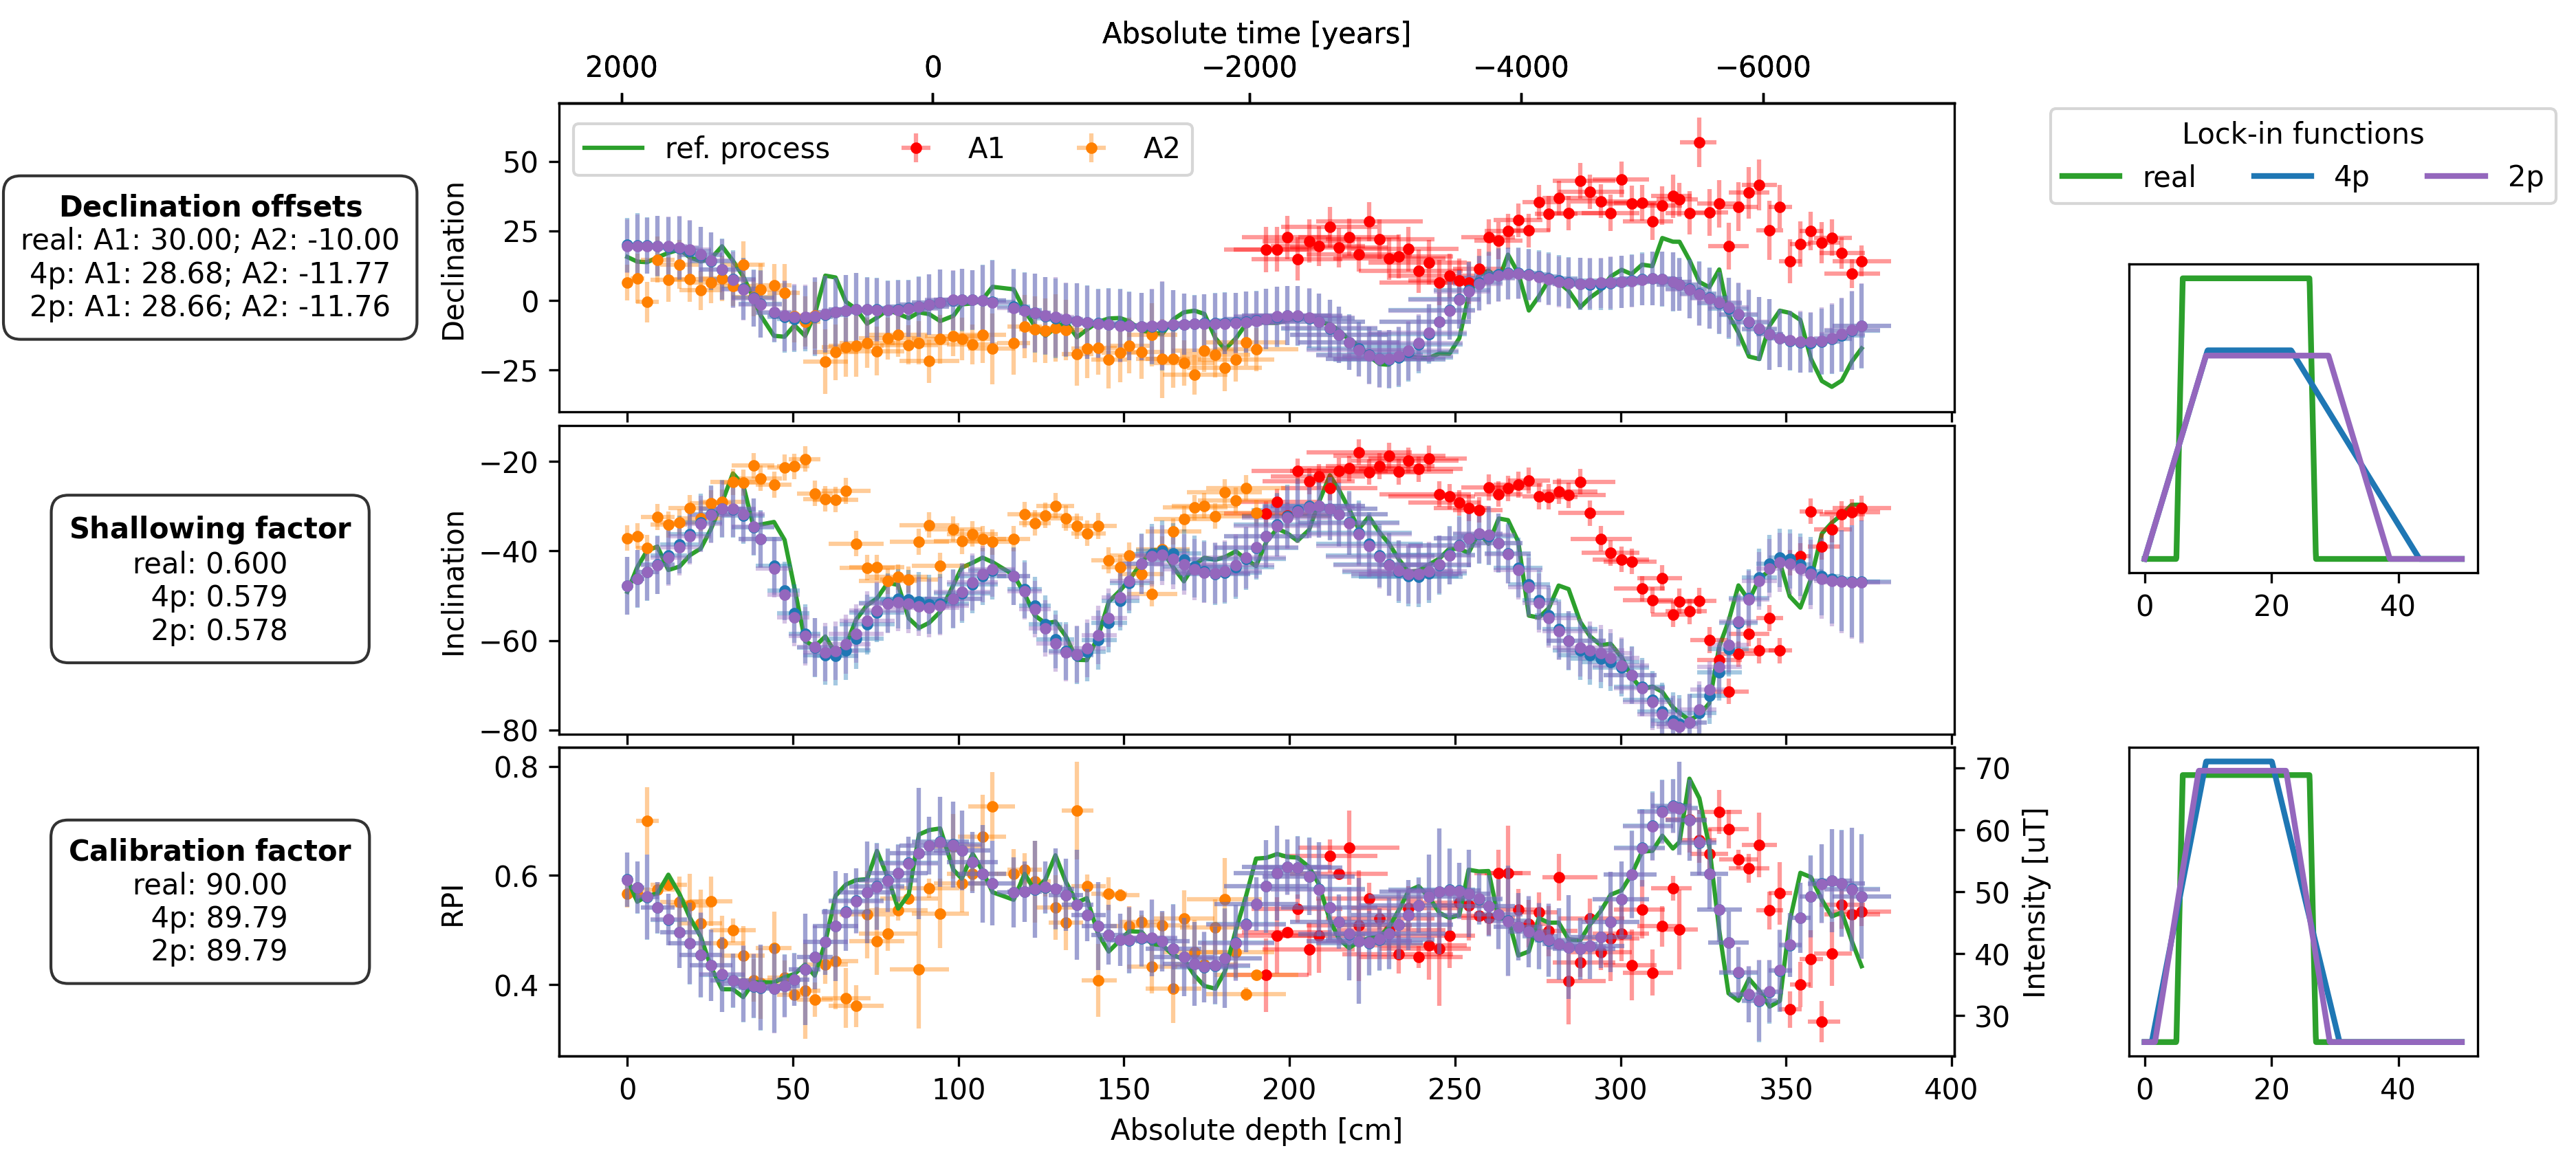

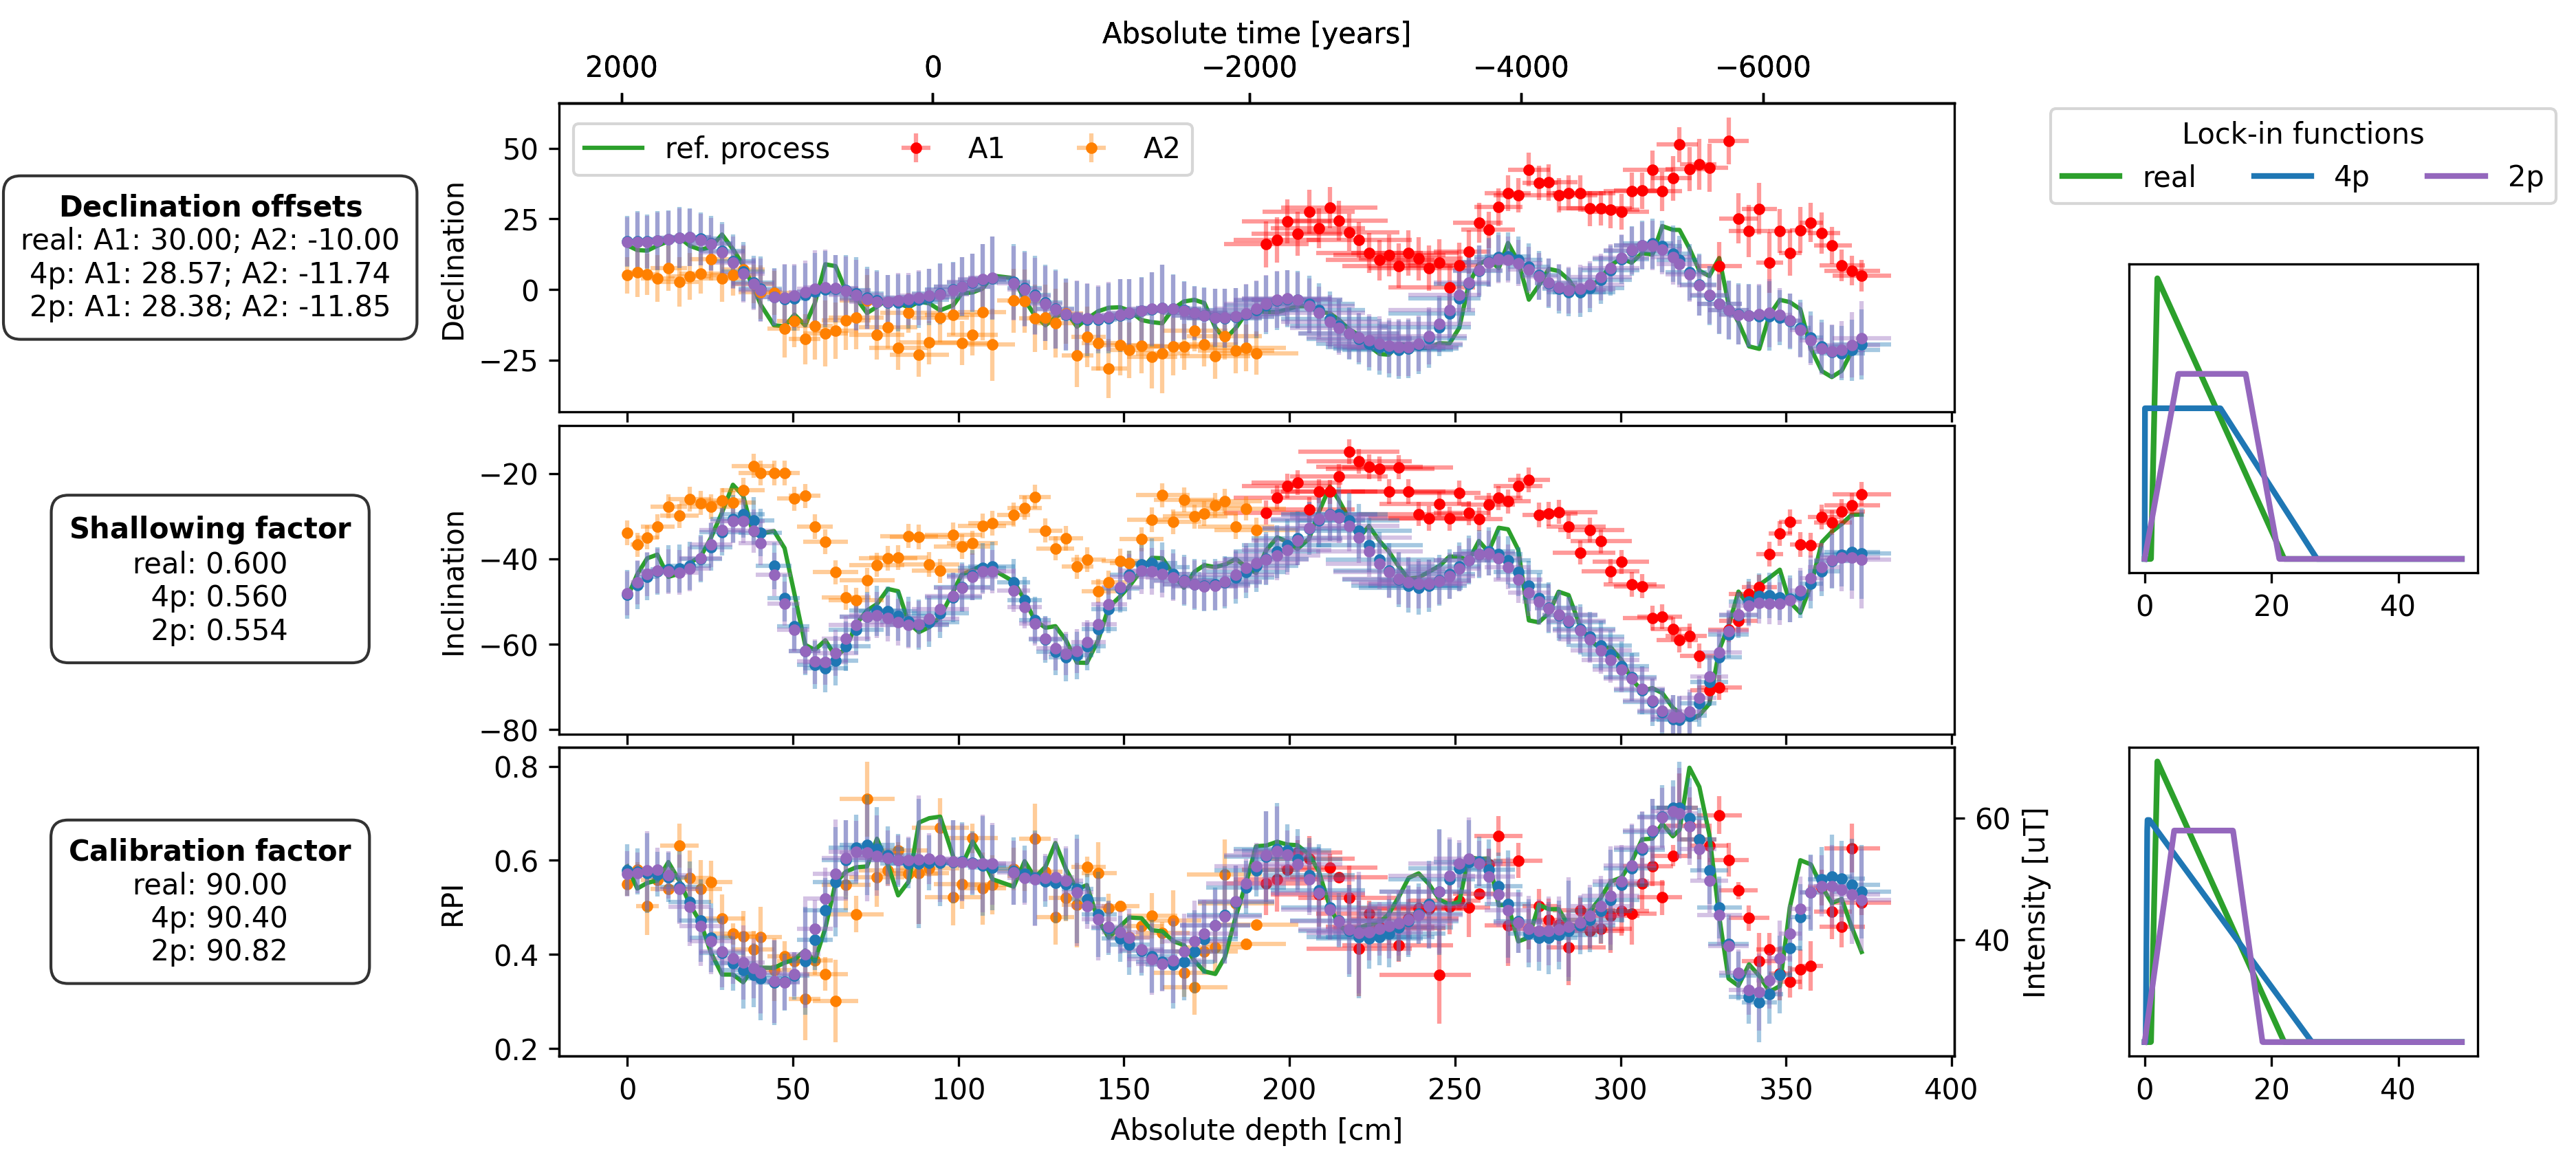

In [10]:
lif_knots = np.linspace(0, 50, 1000)
props = dict(boxstyle='round,pad=0.6', facecolor='none', alpha=0.8)
for loc in ["sweden", "rapa"]:
    ref_sed = pd.read_csv(f"{folder}/ref_sed_{loc}.csv")
    for file in ["triangle", "square", "ramp"]:
        name = f"{loc}_{file}"
        sed = pd.read_csv(f"{folder}/sed_{name}.csv")
        res_DI = pd.read_csv(f"../results/sed_{name}_DI.csv")
        res_F = pd.read_csv(f"../results/sed_{name}_F.csv")
        est_bs_DI_4p = ast.literal_eval(res_DI[res_DI.optimizer=="scipy"].bs_DI.values[0])
        est_bs_F_4p = ast.literal_eval(res_F[res_F.optimizer=="scipy"].bs_F.values[0])
        est_bs_DI_2p = ast.literal_eval(res_DI[res_DI.optimizer=="scipy"].bs_DI.values[1])
        est_bs_F_2p = ast.literal_eval(res_F[res_F.optimizer=="scipy"].bs_F.values[1])
        est_offsets_4p = json.loads(res_DI[res_DI.optimizer=="scipy"].offsets.values[0].replace("'", '"'))
        est_offsets_2p = json.loads(res_DI[res_DI.optimizer=="scipy"].offsets.values[1].replace("'", '"'))
        est_f_shallow_4p = res_DI[res_DI.optimizer=="scipy"].f_shallow.values[0]
        est_f_shallow_2p = res_DI[res_DI.optimizer=="scipy"].f_shallow.values[1]
        est_cal_fac_4p = res_F[res_F.optimizer=="scipy"].cal_fac.values[0]
        est_cal_fac_2p = res_F[res_F.optimizer=="scipy"].cal_fac.values[1]
        fig, axs = plt.subplot_mosaic(
            2 * [3 * ["D"] + ["."]]
            + 2 * [3 * ["D"] + ["LIF_DI"]]
            + 2 * [3 * ["I"] + ["LIF_DI"]]
            + 2 * [3 * ["I"] + ["."]]
            + 4 * [3 * ["F"] + ["LIF_F"]], figsize=(12, 6), dpi=300)
        fig.align_ylabels()
        plt.subplots_adjust(wspace=0.5, hspace=0.2) 
        axF_twin = axs["F"].twinx()
        for ax, comp in zip([axs["D"], axs["I"], axF_twin], ["D", "I", "F"]):
            ax.plot(ref_sed.depth, ref_sed[comp], c="C2", label="ref. process")
            ax.set_xticklabels([]) if comp != "F" else None
        plot_DIF(sed, axs["D"], axs["I"], axs["F"], time_or_depth="depth", xerr=True, yerr=True, legend=False)
        axs["D"].legend(bbox_to_anchor=(0, 0.98), loc="upper left", ncol=3)
        plot_DIF(prep_dfs[name + "_4p"], axs["D"], axs["I"], axF_twin, time_or_depth="depth", xerr=True, yerr=True, legend=False, distinguish_subs=False)
        plot_DIF(prep_dfs[name + "_2p"], axs["D"], axs["I"], axF_twin, time_or_depth="depth", xerr=True, yerr=True, legend=False, distinguish_subs=False, color="C4")
        axF_twin.set_ylabel("Intensity [uT]")
        for ax, bs, bs_4p, bs_2p in zip([axs["LIF_DI"], axs["LIF_F"]], [bs_DIs, bs_Fs], [est_bs_DI_4p, est_bs_F_4p], [est_bs_DI_2p, est_bs_F_2p]):
            ax.plot(lif_knots, lif(bs[file])(lif_knots), c="C2", lw=2, zorder=2, label="real")
            ax.plot(lif_knots, lif(bs_4p)(lif_knots), c="C0", lw=2, zorder=3, label="4p")
            ax.plot(lif_knots, lif(bs_2p)(lif_knots), c="C4", lw=2, zorder=3, label="2p")
            ax.set_yticks([], [])
        axs["LIF_DI"].legend(bbox_to_anchor=(0.5, 1.35), title="Lock-in functions", loc="center", ncol=3)
        offsets_text = r"$\bf{Declination\ offsets}$" + "\n"
        offsets_text += f"real: A1: {offsets['A1']:.2f}; A2: {offsets['A2']:.2f}\n"
        offsets_text += f"4p: A1: {est_offsets_4p['A1']:.2f}; A2: {est_offsets_4p['A2']:.2f}\n"
        offsets_text += f"2p: A1: {est_offsets_2p['A1']:.2f}; A2: {est_offsets_2p['A2']:.2f}"
        f_shallow_text = r"$\bf{Shallowing\ factor}$" + "\n"
        f_shallow_text += f"real: {f_shallow:.3f}\n"
        f_shallow_text += f"  4p: {est_f_shallow_4p:.3f}\n"
        f_shallow_text += f"  2p: {est_f_shallow_2p:.3f}"
        cal_fac_text = r"$\bf{Calibration\ factor}$" + "\n"
        cal_fac_text += f"real: {cal_fac:.2f}\n"
        cal_fac_text += f"  4p: {est_cal_fac_4p:.2f}\n"
        cal_fac_text += f"  2p: {est_cal_fac_2p:.2f}"
        axs["D"].text(-0.25, 0.5, offsets_text, transform=axs["D"].transAxes, va="center", ha="center", bbox=props)
        axs["I"].text(-0.25, 0.5, f_shallow_text, transform=axs["I"].transAxes, va="center", ha="center", bbox=props)
        axs["F"].text(-0.25, 0.5, cal_fac_text, transform=axs["F"].transAxes, va="center", ha="center", bbox=props)
        # fig.suptitle(f"Results for {name}", x=0, fontweight="bold")
        # plt.savefig(
        #     f"../../../paper_3/65c4d0ebd16cb35403bef57e/{name}.png",
        #     bbox_inches="tight",
        # )